[19:01:46] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 3 


SMILES : CCC(O)CC(=O)OC(CC)CC(=O)OC(CC)CC(=O)OC(CC)CC(=O)OC(CC)CC(=O)OCCOC(=O)CC(CC)OC(=O)CCC(=O)OCCOC(=O)OCCCC(=O)OC(CC)CC(=O)OC(CC)CC(=O)OC(CC)CC(=O)OCCOC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CC(CC)OC(=O)OCCCC(=O)OCCOC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CC(CC)OC(=O)OCCCC(=O)OC(CC)CC(=O)OCCOC(=O)CC(CC)OC(=O)CC(CC)OC(=O)OCCCC(=O)OC(CC)CC(=O)OC(CC)CC(=O)OC(CC)CC(=O)OC(CC)CC(=O)OCCOC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CC(CC)OC(=O)OCCCC(=O)OC(CC)CC(=O)OC(CC)CC(=O)OC(CC)CC(=O)OCCOC(=O)OCCCC(=O)OCCOC(=O)OCCCC(=O)OCCOC(=O)OCCCC(=O)OC(CC)CC(=O)OC(CC)CC(=O)OC(CC)CC(=O)OC(=O)CCCOC(=O)OCCOC(=O)CC(CC)OC(=O)CCCOC(=O)OCCOC(=O)CC(CC)OC(=O)CCCOC(=O)OCCOC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CCC(=O)OC(CC)CC(=O)OC(CC)CC(=O)OC(CC)CC(=O)OCCOC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CCCOC(=O)OC(CC)CC(=O)OC(CC)CC(=O)OCCOC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CCCOC(=O)OC(CC)CC(=O)OC(CC)CC(=O)OCCOC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CCCOC(=O)OC

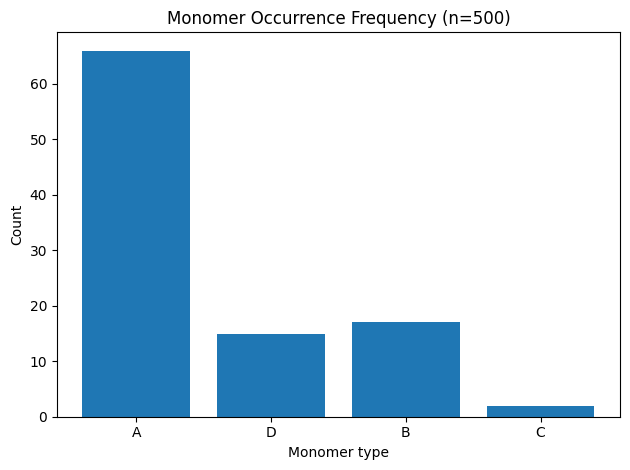

In [5]:
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
import random, collections
import collections
from collections import Counter
import matplotlib.pyplot as plt


# 1. モノマー定義
monomers = {
    "A": {"smiles": "OC(CC)CC(=O)O",    "ends": ["OH", "COOH"]},
    "B": {"smiles": "OCCO",             "ends": ["OH", "OH"]},
    "C": {"smiles": "OC(=O)CCC(=O)O",   "ends": ["COOH", "COOH"]},
    "D": {"smiles": "OC(=O)CCCOC(=O)O", "ends": ["COOH", "COOH"]},
}
mole_ratio = {"A":0.5,"B":0.25,"C":0.01,"D":0.24}

# 2. 縮合反応
rxn = AllChem.ReactionFromSmarts("[C:1](=[O:2])[OH:3].[OH:4][C:5]>>[C:1](=[O:2])[O:4][C:5]")

# 3. ユーティリティ
def w_choice(d):
    r = random.uniform(0, sum(d.values()))
    s = 0
    for k,w in d.items():
        s += w
        if r<=s:
            return k
    return k

def remove_one(counter, key):
    if counter[key] > 0:
        counter[key] -= 1
        if counter[key] == 0:
            del counter[key]

# 4. ポリマー生成
def build_polymer(target_units=20, seed=None):
    if seed is not None and seed >= 0:     # ★ seed=-1 ならランダム
        random.seed(seed)

    key = w_choice(mole_ratio)
    polymer   = Chem.MolFromSmiles(monomers[key]["smiles"])
    Chem.SanitizeMol(polymer)
    ends      = collections.Counter(monomers[key]["ends"])
    units     = 1
    sequence  = [key]                       # ★ シーケンス開始

    while units < target_units:
        # 末端にマッチする候補
        if   "OH"  in ends and "COOH" not in ends:
            pool = {m:w for m,w in mole_ratio.items() if "COOH" in monomers[m]["ends"]}
        elif "COOH" in ends and "OH"   not in ends:
            pool = {m:w for m,w in mole_ratio.items() if "OH"   in monomers[m]["ends"]}
        else:
            pool = mole_ratio

        if not pool:
            break

        next_key  = w_choice(pool)
        next_mol  = Chem.MolFromSmiles(monomers[next_key]["smiles"])
        Chem.SanitizeMol(next_mol)
        next_ends = collections.Counter(monomers[next_key]["ends"])

        choices = [
            (polymer, next_mol,  ends.copy(), next_ends.copy()),
            (next_mol, polymer,  next_ends.copy(), ends.copy())
        ]

        reacted = False
        for acid_mol, alc_mol, acid_ends, alc_ends in choices:
            if "COOH" in acid_ends and "OH" in alc_ends:
                prod = rxn.RunReactants((acid_mol, alc_mol))
                if prod:
                    polymer = prod[0][0]
                    Chem.SanitizeMol(polymer)
                    remove_one(acid_ends, "COOH")
                    remove_one(alc_ends,  "OH")
                    ends   = acid_ends + alc_ends
                    units += 1
                    sequence.append(next_key)   # ★ ユニット追加
                    reacted = True
                    break
        if not reacted:
            continue

    return Chem.MolToSmiles(polymer), units, sequence   # ★ 返り値拡張

# 5. 全記述子計算
def calc_all_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return {"ERROR": "Invalid SMILES"}
    Chem.SanitizeMol(mol)
    return {name: func(mol) for name, func in Descriptors.descList}

# 6. 実行例
if __name__ == "__main__":
    smi, dp, seq = build_polymer(target_units=100, seed=-1)  # seed=-1 → ランダム
    print("SMILES :", smi)
    print("Degree :", dp)
    print("Sequence:", seq)                      # ★ シーケンス表示

    descs = calc_all_descriptors(smi)
    print("\nDescriptors:")
    for k, v in descs.items():
        print(f"{k:30}: {v}")

    freq = Counter(seq)

    # plot
    labels = list(freq.keys())
    values = [freq[l] for l in labels]

    plt.figure()
    plt.bar(labels, values)
    plt.title("Monomer Occurrence Frequency (n=500)")
    plt.xlabel("Monomer type")
    plt.ylabel("Count")
    plt.tight_layout()

